In [1]:
import pandas as pd
import numpy as np
import os, time, stat, io, glob, pickle
from scipy.stats import gamma, norm
from sklearn.linear_model import LinearRegression

from IPython.core.display import display, HTML

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('fivethirtyeight')
import plotly.io as pio

%load_ext autoreload
%autoreload 2
from covid_data_helper import *
from coronita_chart_helper import *
from coronita_model_helper import *

from matplotlib.backends.backend_pdf import PdfPages
from PyPDF2 import PdfFileWriter, PdfFileReader

def footnote_str_maker():
    footnote_str = 'Author: Michael Donnelly | twtr: @donnellymjd | www.covidoutlook.info\nChart created on {}'.format(
        pd.Timestamp.today().strftime("%d %b, %Y at %I:%M %p"))
    return footnote_str

def add_plotly_footnote(fig):
    fig.update_layout(
                  annotations=[
                      dict(x = 0, y = -0.06, font_size=10, showarrow=False,
                           xref='paper', yref='paper',
                           xanchor='left', yanchor='auto', xshift=0, yshift=0,
                           text='Author: Michael Donnelly | twtr: <a href="https://twitter.com/donnellymjd">@donnellymjd</a> | <a href="http://{0}">{0}</a>'.format(
                           'www.michaeldonnel.ly')
                          ),
                      dict(x = 0, y = -0.09, font_size=10, showarrow=False,
                           xref='paper', yref='paper',
                           xanchor='left', yanchor='auto', xshift=0, yshift=0,
                           text='Chart created on {}'.format(pd.Timestamp.today().strftime("%d %b %Y"))
                          )
                  ]
                 )
    return fig


In [2]:
df_st_testing_raw = pd.read_csv(
# 'https://raw.githubusercontent.com/COVID19Tracking/covid-tracking-data/master/data/states_daily_4pm_et.csv')
    'https://api.covidtracking.com/v1/states/daily.csv')
df_st_testing = df_st_testing_raw
df_st_testing['dt'] = pd.to_datetime(df_st_testing['date'], format="%Y%m%d")
print("State Testing Data Last Observation: ", df_st_testing.date.max())
df_st_testing = df_st_testing.rename(columns={'state':'code'})
df_st_testing = df_st_testing.set_index(['code','dt']).sort_index()
print('Got COVID19 Tracking Data')
df_st_testing


State Testing Data Last Observation:  20210307
Got COVID19 Tracking Data


date  positive  probableCases  negative  pending  \
code dt                                                                 
AK   2020-03-06  20200306       NaN            NaN       NaN      1.0   
     2020-03-07  20200307       NaN            NaN       NaN      2.0   
     2020-03-08  20200308       NaN            NaN       NaN      6.0   
     2020-03-09  20200309       NaN            NaN       NaN      9.0   
     2020-03-10  20200310       NaN            NaN       NaN      9.0   
...                   ...       ...            ...       ...      ...   
WY   2021-03-03  20210303   54616.0         8348.0  181681.0      NaN   
     2021-03-04  20210304   54685.0         8357.0  181957.0      NaN   
     2021-03-05  20210305   54764.0         8367.0  182264.0      NaN   
     2021-03-06  20210306   54764.0         8367.0  182264.0      NaN   
     2021-03-07  20210307   54764.0         8367.0  182264.0      NaN   

                totalTestResultsSource  totalTestResults  \
code dt                                                    
AK   2020-03-06        totalTestsViral               8.0   
     2020-03-07        totalTestsViral              12.0   
     2020-03-08        totalTestsViral              14.0   
     2020-03-09        totalTestsViral              23.0   
     2020-03-10        totalTestsViral              23.0   
...                                ...               ...   
WY   2021-03-03        totalTestsViral          643476.0   
     2021-03-04        totalTestsViral          646179.0   
     2021-03-05        totalTestsViral          649293.0   
     2021-03-06        totalTestsViral          649293.0   
     2021-03-07        totalTestsViral          649293.0   

                 hospitalizedCurrently  hospitalizedCumulative  \
code dt                                                          
AK   2020-03-06                    NaN                     NaN   
     2020-03-07                    NaN                     NaN   
     2020-03-08                    NaN                     NaN   
     2020-03-09                    NaN                     1.0   
     2020-03-10                    NaN                     1.0   
...                                ...                     ...   
WY   2021-03-03                   24.0                  1388.0   
     2021-03-04                   23.0                  1389.0   
     2021-03-05                   21.0                  1391.0   
     2021-03-06                   21.0                  1391.0   
     2021-03-07                   21.0                  1391.0   

                 inIcuCurrently  ...  dataQualityGrade  deathIncrease  \
code dt                          ...                                    
AK   2020-03-06             NaN  ...               NaN              0   
     2020-03-07             NaN  ...               NaN              0   
     2020-03-08             NaN  ...               NaN              0   
     2020-03-09             NaN  ...               NaN              0   
     2020-03-10             NaN  ...               NaN              0   
...                         ...  ...               ...            ...   
WY   2021-03-03             NaN  ...               NaN              0   
     2021-03-04             NaN  ...               NaN              0   
     2021-03-05             NaN  ...               NaN              0   
     2021-03-06             NaN  ...               NaN              0   
     2021-03-07             NaN  ...               NaN              0   

                 hospitalizedIncrease  \
code dt                                 
AK   2020-03-06                     0   
     2020-03-07                     0   
     2020-03-08                     0   
     2020-03-09                     1   
     2020-03-10                     0   
...                               ...   
WY   2021-03-03                     3   
     2021-03-04                     1   
     2021-03-05                     2   
     2021-03-06               

In [3]:
df_st_testing.columns

Index(['date', 'positive', 'probableCases', 'negative', 'pending',
       'totalTestResultsSource', 'totalTestResults', 'hospitalizedCurrently',
       'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative',
       'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered',
       'lastUpdateEt', 'dateModified', 'checkTimeEt', 'death', 'hospitalized',
       'hospitalizedDischarged', 'dateChecked', 'totalTestsViral',
       'positiveTestsViral', 'negativeTestsViral', 'positiveCasesViral',
       'deathConfirmed', 'deathProbable', 'totalTestEncountersViral',
       'totalTestsPeopleViral', 'totalTestsAntibody', 'positiveTestsAntibody',
       'negativeTestsAntibody', 'totalTestsPeopleAntibody',
       'positiveTestsPeopleAntibody', 'negativeTestsPeopleAntibody',
       'totalTestsPeopleAntigen', 'positiveTestsPeopleAntigen',
       'totalTestsAntigen', 'positiveTestsAntigen', 'fips', 'positiveIncrease',
       'negativeIncrease', 'total', 'totalTestResultsIncrease', 'posNeg',

In [4]:
['deaths', 'hospitalizedCurrently', 'hospitalizedIncrease', 'cases', 'posNeg']

['deaths', 'hospitalizedCurrently', 'hospitalizedIncrease', 'cases', 'posNeg']

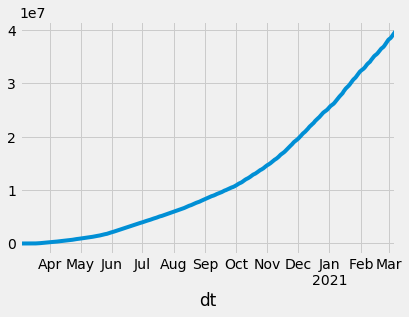

In [5]:
df_st_testing.loc['NY']['totalTestResults'].plot()

In [89]:
df_cdc_raw = pd.read_csv('https://data.cdc.gov/api/views/9mfq-cb36/rows.csv?accessType=DOWNLOAD')
rename_cols ={'state':'code', 'submission_date':'dt','tot_death':'death', 'tot_cases':'cases'}
df_cdc = df_cdc_raw[rename_cols.keys()]
df_cdc = df_cdc.rename(columns = rename_cols)
df_cdc['dt'] = pd.to_datetime(df_cdc['dt']).dt.normalize()
df_cdc = df_cdc.set_index(['code','dt']).sort_index()
df_cdc

death  cases
code dt                      
AK   2020-01-22      0      0
     2020-01-23      0      0
     2020-01-24      0      0
     2020-01-25      0      0
     2020-01-26      0      0
...                ...    ...
WY   2021-03-03    682  54616
     2021-03-04    682  54685
     2021-03-05    682  54764
     2021-03-06    682  54764
     2021-03-07    682  54764

[24660 rows x 2 columns]

In [6]:
df_hhs_hosp_raw = pd.read_csv('https://beta.healthdata.gov/api/views/g62h-syeh/rows.csv?accessType=DOWNLOAD')
df_hhs_hosp_raw

,state,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,...,inpatient_bed_covid_utilization_denominator,adult_icu_bed_covid_utilization,adult_icu_bed_covid_utilization_coverage,adult_icu_bed_covid_utilization_numerator,adult_icu_bed_covid_utilization_denominator,adult_icu_bed_utilization,adult_icu_bed_utilization_coverage,adult_icu_bed_utilization_numerator,adult_icu_bed_utilization_denominator,geocoded_state
0,WI,12/20/2020 12:00:00 AM,45,97,7,50,92,7,16.0,146,...,13562.0,0.207535,144.0,325.0,1566.0,0.590853,148.0,956.0,1618.0,POINT (-89.732969 44.639954)
1,WV,12/20/2020 12:00:00 AM,19,40,4,21,38,4,10.0,59,...,6043.0,0.257669,59.0,168.0,652.0,0.734838,63.0,521.0,709.0,POINT (-80.613729 38.642579)
2,WY,12/20/2020 12:00:00 AM,5,24,2,7,22,2,1.0,29,...,1675.0,0.244094,29.0,31.0,127.0,0.434783,31.0,60.0,138.0,POINT (-107.55145 42.999627)
3,AK,12/19/2020 12:00:00 AM,4,20,0,3,21,0,2.0,24,...,1623.0,0.138462,24.0,18.0,130.0,0.730769,24.0,95.0,130.0,POINT (-151.631889 63.631126)
4,AL,12/19/2020 12:00:00 AM,37,74,6,41,69,7,20.0,113,...,15220.0,0.402242,113.0,646.0,1606.0,0.897202,117.0,1475.0,1644.0,POINT (-86.844516 32.756889)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19886,MN,01/01/2020 12:00:00 AM,0,0,1,0,0,1,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-94.198308 46.349153)
19887,MT,01/01/2020 12:00:00 AM,0,0,1,0,0,1,0.0,1,...,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-109.645127 47.033521)
19888,NC,01/01/2020 12:00:00 AM,0,0,1,0,0,1,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-79.130883 35.52603)
19889,PR,01/01/2020 12:00:00 AM,0,0,1,0,0,1,0.0,1,...,146.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-66.414655 18.215692)


In [8]:
df_hhs_hosp = df_hhs_hosp_raw
df_hhs_hosp = df_hhs_hosp.rename(columns = {'state':'code', 'date':'dt'})
df_hhs_hosp['dt'] = pd.to_datetime(df_hhs_hosp['dt']).dt.normalize()
df_hhs_hosp = df_hhs_hosp.set_index(['code','dt'])
df_hhs_hosp['hospitalizedIncrease'] = df_hhs_hosp[[
    'previous_day_admission_adult_covid_confirmed',
    'previous_day_admission_adult_covid_suspected',
    'previous_day_admission_pediatric_covid_confirmed',
    'previous_day_admission_pediatric_covid_suspected']].sum(axis=1)
df_hhs_hosp['hospitalizedCurrently'] = df_hhs_hosp[[
    'total_adult_patients_hospitalized_confirmed_and_suspected_covid',
    'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid']].sum(axis=1)
df_hhs_hosp = df_hhs_hosp[['hospitalizedIncrease', 'hospitalizedCurrently']].sort_index()
df_hhs_hosp


hospitalizedIncrease  hospitalizedCurrently
code dt                                                     
AK   2020-03-23                   0.0                    0.0
     2020-03-24                   0.0                    0.0
     2020-03-25                   0.0                    0.0
     2020-03-26                   0.0                    0.0
     2020-03-27                   0.0                    0.0
...                               ...                    ...
WY   2021-03-02                  26.0                   36.0
     2021-03-03                  20.0                   29.0
     2021-03-04                  15.0                   29.0
     2021-03-05                  15.0                   27.0
     2021-03-06                  15.0                   27.0

[19891 rows x 2 columns]

In [42]:
df_hosp_concur_joint = pd.concat([
    df_st_testing['hospitalizedCurrently'].unstack(['code']).loc[:'2020-08-31'].stack('code'),
          df_hhs_hosp['hospitalizedCurrently'].unstack(['code']).loc['2020-09-01':].stack('code')]
         )
df_hosp_concur_joint = df_hosp_concur_joint.swaplevel().sort_index()
df_hosp_concur_joint


code  dt        
AK    2020-04-18    39.0
      2020-04-19    37.0
      2020-04-20    46.0
      2020-04-21    42.0
      2020-04-22    39.0
                    ... 
WY    2021-03-02    36.0
      2021-03-03    29.0
      2021-03-04    29.0
      2021-03-05    27.0
      2021-03-06    27.0
Length: 17287, dtype: float64

In [46]:
df_hosp_admits_joint = pd.concat([
    df_st_testing['hospitalizedIncrease'].unstack(['code']).loc[:'2020-08-31'].stack('code'),
          df_hhs_hosp['hospitalizedIncrease'].unstack(['code']).loc['2020-09-01':].stack('code')]
         )
df_hosp_admits_joint = df_hosp_admits_joint.swaplevel().sort_index()
df_hosp_admits_joint


code  dt        
AK    2020-03-06     0.0
      2020-03-07     0.0
      2020-03-08     0.0
      2020-03-09     1.0
      2020-03-10     0.0
                    ... 
WY    2021-03-02    26.0
      2021-03-03    20.0
      2021-03-04    15.0
      2021-03-05    15.0
      2021-03-06    15.0
Length: 20163, dtype: float64

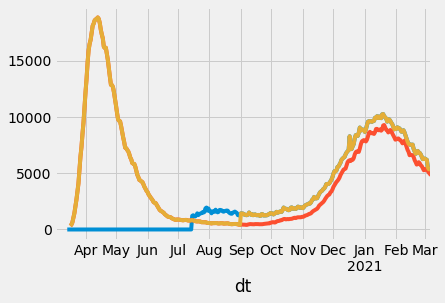

In [45]:
state = 'NY'
df_hhs_hosp.loc[state,'hospitalizedCurrently'].plot()
df_st_testing.loc[state,'hospitalizedCurrently'].plot()
df_hosp_concur_joint.loc[(state)].plot()

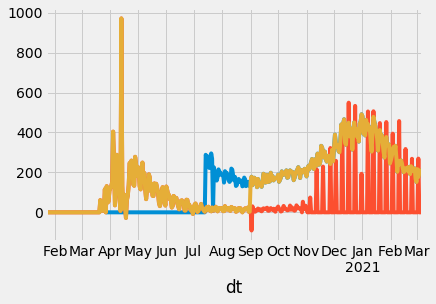

In [50]:
state = 'MA'
df_hhs_hosp.loc[state,'hospitalizedIncrease'].plot()
df_st_testing.loc[state,'hospitalizedIncrease'].plot()
df_hosp_admits_joint.loc[(state)].plot()

In [168]:
df_hhs_tests_raw = pd.read_csv('https://healthdata.gov/api/views/j8mb-icvb/rows.csv?accessType=DOWNLOAD')
df_hhs_tests = df_hhs_tests_raw.copy()

df_hhs_tests = df_hhs_tests.rename(columns = {'state':'code', 'date':'dt'})
df_hhs_tests['dt'] = pd.to_datetime(df_hhs_tests['dt']).dt.normalize()
df_hhs_tests = df_hhs_tests.set_index(['code','dt','overall_outcome'])['total_results_reported']
df_hhs_tests = df_hhs_tests.unstack('overall_outcome')
df_hhs_tests['posNeg'] = df_hhs_tests[['Inconclusive','Negative','Positive']].sum(axis=1)
df_hhs_tests = df_hhs_tests.rename(columns={'Positive':'positive'})
df_hhs_tests = df_hhs_tests[['positive','posNeg']]

df_hhs_tests

overall_outcome  positive    posNeg
code dt                            
AK   2020-03-01       NaN       4.0
     2020-03-02       NaN       4.0
     2020-03-03       NaN       6.0
     2020-03-04       NaN      18.0
     2020-03-05       NaN      27.0
...                   ...       ...
WY   2021-03-06   47578.0  678400.0
     2021-03-07   47611.0  679504.0
     2021-03-08   47621.0  679886.0
     2021-03-09   47640.0  680451.0
     2021-03-10   47706.0  683070.0

[20345 rows x 2 columns]

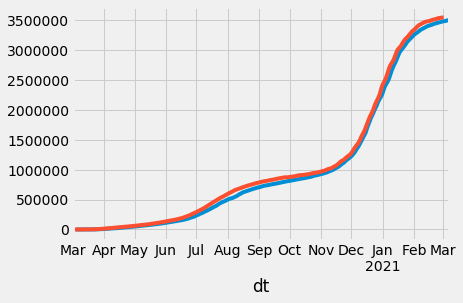

In [67]:
state = 'CA' 
df_st_testing.loc[state,'positive'].plot()
df_hhs_tests.loc[state,'positive'].plot()

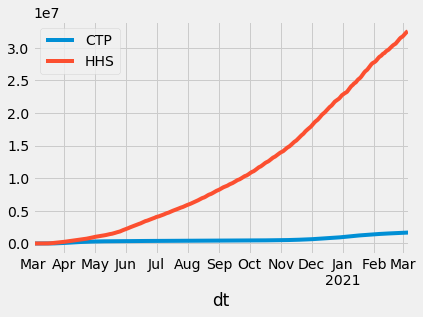

In [72]:
#NOTE: It looks like CTP screwed up the posneg data column and is just reporting positive tests there.
state = 'NY' 
df_st_testing.loc[state,'posNeg'].plot(legend=True, label='CTP')
df_hhs_tests.loc[state,'posNeg'].plot(legend=True, label='HHS')

In [75]:
df_hhs_tests.loc[state]

overall_outcome,Inconclusive,Negative,positive,posNeg
dt,,,,
2020-03-01,NaN,3.0,1.0,4.0
2020-03-02,NaN,4.0,7.0,11.0
2020-03-03,NaN,26.0,7.0,33.0
2020-03-04,NaN,92.0,51.0,143.0
2020-03-05,NaN,207.0,95.0,302.0
...,...,...,...,...
2021-03-02,41238.0,30057442.0,1800492.0,31899172.0
2021-03-03,41371.0,30229120.0,1809002.0,32079493.0
2021-03-04,41525.0,30403566.0,1817087.0,32262178.0


In [90]:
df_st_testing_federal = pd.concat([
    df_cdc, 
    df_hhs_tests, 
    df_hhs_hosp])
df_st_testing_federal


death  cases  positive  posNeg  hospitalizedIncrease  \
code dt                                                                 
AK   2020-01-22    0.0    0.0       NaN     NaN                   NaN   
     2020-01-23    0.0    0.0       NaN     NaN                   NaN   
     2020-01-24    0.0    0.0       NaN     NaN                   NaN   
     2020-01-25    0.0    0.0       NaN     NaN                   NaN   
     2020-01-26    0.0    0.0       NaN     NaN                   NaN   
...                ...    ...       ...     ...                   ...   
WY   2021-03-02    NaN    NaN       NaN     NaN                  26.0   
     2021-03-03    NaN    NaN       NaN     NaN                  20.0   
     2021-03-04    NaN    NaN       NaN     NaN                  15.0   
     2021-03-05    NaN    NaN       NaN     NaN                  15.0   
     2021-03-06    NaN    NaN       NaN     NaN                  15.0   

                 hospitalizedCurrently  
code dt                                 
AK   2020-01-22                    NaN  
     2020-01-23                    NaN  
     2020-01-24                    NaN  
     2020-01-25                    NaN  
     2020-01-26                    NaN  
...                                ...  
WY   2021-03-02                   36.0  
     2021-03-03                   29.0  
     2021-03-04                   29.0  
     2021-03-05                   27.0  
     2021-03-06                   27.0  

[64674 rows x 6 columns]

In [95]:
df_st_testing_federal.loc['NY',['cases','positive']]

,cases,positive
dt,,
2020-01-22,0.0,NaN
2020-01-23,0.0,NaN
2020-01-24,0.0,NaN
2020-01-25,0.0,NaN
2020-01-26,0.0,NaN
...,...,...
2021-03-02,NaN,NaN
2021-03-03,NaN,NaN
2021-03-04,NaN,NaN


In [99]:
df_st_testing_raw = pd.read_csv(
# 'https://raw.githubusercontent.com/COVID19Tracking/covid-tracking-data/master/data/states_daily_4pm_et.csv')
    'https://api.covidtracking.com/v1/states/daily.csv')
df_st_testing = df_st_testing_raw
df_st_testing['dt'] = pd.to_datetime(df_st_testing['date'], format="%Y%m%d")
print("State Testing Data Last Observation: ", df_st_testing.date.max())
df_st_testing = df_st_testing.rename(columns={'state':'code'})
df_st_testing = df_st_testing.set_index(['code','dt']).sort_index()
print('Got COVID19 Tracking Data')

df_cdc_raw = pd.read_csv('https://data.cdc.gov/api/views/9mfq-cb36/rows.csv?accessType=DOWNLOAD')
rename_cols ={'state':'code', 'submission_date':'dt','tot_death':'death', 'tot_cases':'cases'}
df_cdc = df_cdc_raw[rename_cols.keys()]
df_cdc = df_cdc.rename(columns = rename_cols)
df_cdc['dt'] = pd.to_datetime(df_cdc['dt']).dt.normalize()
df_cdc['code'] = df_cdc['code'].replace('NYC', 'NY')
df_cdc = df_cdc.groupby(['code','dt']).sum().sort_index()

df_hhs_tests_raw = pd.read_csv('https://healthdata.gov/sites/default/files/covid-19_diagnostic_lab_testing_20210307_2203.csv')
df_hhs_tests = df_hhs_tests_raw.copy()

df_hhs_tests = df_hhs_tests.rename(columns = {'state':'code', 'date':'dt'})
df_hhs_tests['dt'] = pd.to_datetime(df_hhs_tests['dt']).dt.normalize()
df_hhs_tests = df_hhs_tests.set_index(['code','dt','overall_outcome'])['total_results_reported']
df_hhs_tests = df_hhs_tests.unstack('overall_outcome')
df_hhs_tests['posNeg'] = df_hhs_tests[['Inconclusive','Negative','Positive']].sum(axis=1)
df_hhs_tests = df_hhs_tests.rename(columns={'Positive':'positive'})
df_hhs_tests = df_hhs_tests[['positive','posNeg']]

df_hhs_hosp_raw = pd.read_csv('https://beta.healthdata.gov/api/views/g62h-syeh/rows.csv?accessType=DOWNLOAD')
df_hhs_hosp = df_hhs_hosp_raw
df_hhs_hosp = df_hhs_hosp.rename(columns = {'state':'code', 'date':'dt'})
df_hhs_hosp['dt'] = pd.to_datetime(df_hhs_hosp['dt']).dt.normalize()
df_hhs_hosp = df_hhs_hosp.set_index(['code','dt'])
df_hhs_hosp['hospitalizedIncrease'] = df_hhs_hosp[[
    'previous_day_admission_adult_covid_confirmed',
    'previous_day_admission_adult_covid_suspected',
    'previous_day_admission_pediatric_covid_confirmed',
    'previous_day_admission_pediatric_covid_suspected']].sum(axis=1)
df_hhs_hosp['hospitalizedCurrently'] = df_hhs_hosp[[
    'total_adult_patients_hospitalized_confirmed_and_suspected_covid',
    'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid']].sum(axis=1)
df_hhs_hosp = df_hhs_hosp[['hospitalizedIncrease', 'hospitalizedCurrently']].sort_index()

df_hosp_joint = pd.concat([
    df_st_testing[['hospitalizedIncrease', 'hospitalizedCurrently']].unstack(['code']).loc[:'2020-08-31'].stack('code'),
    df_hhs_hosp[['hospitalizedIncrease', 'hospitalizedCurrently']].unstack(['code']).loc['2020-09-01':].stack('code')]
)
df_hosp_joint = df_hosp_joint.swaplevel().sort_index()

df_st_testing_new = pd.merge(df_cdc['death'], df_hhs_tests, how='outer', left_index=True, right_index=True)
df_st_testing_new = pd.merge(df_st_testing_new, df_hosp_joint, how='outer', left_index=True, right_index=True)
df_st_testing_new


State Testing Data Last Observation:  20210307
Got COVID19 Tracking Data


death  positive  posNeg  hospitalizedIncrease  \
code dt                                                          
AK   2020-01-22    0.0       NaN     NaN                   NaN   
     2020-01-23    0.0       NaN     NaN                   NaN   
     2020-01-24    0.0       NaN     NaN                   NaN   
     2020-01-25    0.0       NaN     NaN                   NaN   
     2020-01-26    0.0       NaN     NaN                   NaN   
...                ...       ...     ...                   ...   
WY   2021-03-03  682.0       NaN     NaN                  20.0   
     2021-03-04  682.0       NaN     NaN                  15.0   
     2021-03-05  682.0       NaN     NaN                  15.0   
     2021-03-06  682.0       NaN     NaN                  15.0   
     2021-03-07  682.0       NaN     NaN                   NaN   

                 hospitalizedCurrently  
code dt                                 
AK   2020-01-22                    NaN  
     2020-01-23                    NaN  
     2020-01-24                    NaN  
     2020-01-25                    NaN  
     2020-01-26                    NaN  
...                                ...  
WY   2021-03-03                   29.0  
     2021-03-04                   29.0  
     2021-03-05                   27.0  
     2021-03-06                   27.0  
     2021-03-07                    NaN  

[24825 rows x 5 columns]

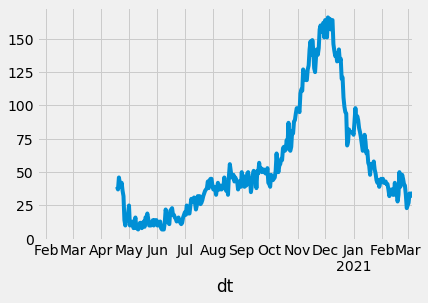

In [118]:
df_st_testing_new.loc['AK','hospitalizedCurrently'].plot()

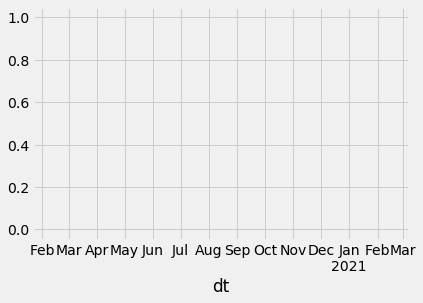

In [124]:
df_cdc.loc['NY'] = df_cdc.loc['NYC'].add(df_cdc.loc['NY'])
df_cdc.loc['NY']['death'].plot()

death    cases
code dt                        
AK   2020-01-22    0.0      0.0
     2020-01-23    0.0      0.0
     2020-01-24    0.0      0.0
     2020-01-25    0.0      0.0
     2020-01-26    0.0      0.0
...                ...      ...
WY   2021-03-03  682.0  54616.0
     2021-03-04  682.0  54685.0
     2021-03-05  682.0  54764.0
     2021-03-06  682.0  54764.0
     2021-03-07  682.0  54764.0

[24660 rows x 2 columns]

In [130]:
df_can_raw = pd.read_csv('https://api.covidactnow.org/v2/states.timeseries.csv?apiKey=249c0d9107464d8cafe24dd34be843d8')



In [131]:
df_can_raw.columns

Index(['date', 'country', 'state', 'county', 'fips', 'lat', 'long',
       'locationId', 'actuals.cases', 'actuals.deaths',
       'actuals.positiveTests', 'actuals.negativeTests',
       'actuals.contactTracers', 'actuals.hospitalBeds.capacity',
       'actuals.hospitalBeds.currentUsageTotal',
       'actuals.hospitalBeds.currentUsageCovid',
       'actuals.hospitalBeds.typicalUsageRate', 'actuals.icuBeds.capacity',
       'actuals.icuBeds.currentUsageTotal',
       'actuals.icuBeds.currentUsageCovid', 'actuals.icuBeds.typicalUsageRate',
       'actuals.newCases', 'actuals.vaccinesDistributed',
       'actuals.vaccinationsInitiated', 'actuals.vaccinationsCompleted',
       'metrics.testPositivityRatio', 'metrics.testPositivityRatioDetails',
       'metrics.caseDensity', 'metrics.contactTracerCapacityRatio',
       'metrics.infectionRate', 'metrics.infectionRateCI90',
       'metrics.icuHeadroomRatio', 'metrics.icuHeadroomDetails',
       'metrics.icuCapacityRatio', 'riskLevels.overall

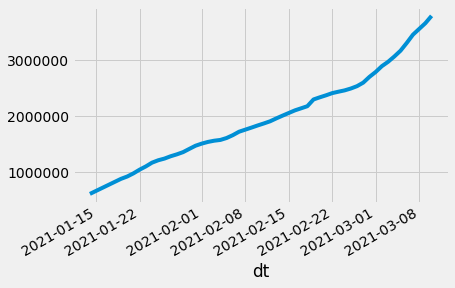

In [136]:
df_can.loc['NY','actuals.vaccinationsInitiated'].dropna().plot()

In [132]:
df_can = df_can_raw.copy()
df_can = df_can.rename(columns={'date':'dt','state':'code'})
df_can['dt'] = pd.to_datetime(df_can['dt']).dt.normalize()
df_can = df_can.set_index(['code','dt'])

# df_can['posNeg'] = df_can[['Inconclusive','Negative','Positive']].sum(axis=1)
# df_can = df_can.rename(columns={'Positive':'positive'})
df_can

country  county  fips  lat  long          locationId  \
code dt                                                                
AK   2020-03-01     USA     NaN     2  NaN   NaN  iso1:us#iso2:us-ak   
     2020-03-02     USA     NaN     2  NaN   NaN  iso1:us#iso2:us-ak   
     2020-03-03     USA     NaN     2  NaN   NaN  iso1:us#iso2:us-ak   
     2020-03-04     USA     NaN     2  NaN   NaN  iso1:us#iso2:us-ak   
     2020-03-05     USA     NaN     2  NaN   NaN  iso1:us#iso2:us-ak   
...                 ...     ...   ...  ...   ...                 ...   
WY   2021-03-06     USA     NaN    56  NaN   NaN  iso1:us#iso2:us-wy   
     2021-03-07     USA     NaN    56  NaN   NaN  iso1:us#iso2:us-wy   
     2021-03-08     USA     NaN    56  NaN   NaN  iso1:us#iso2:us-wy   
     2021-03-09     USA     NaN    56  NaN   NaN  iso1:us#iso2:us-wy   
     2021-03-10     USA     NaN    56  NaN   NaN  iso1:us#iso2:us-wy   

                 actuals.cases  actuals.deaths  actuals.positiveTests  \
code dt                                                                 
AK   2020-03-01            NaN             NaN                    NaN   
     2020-03-02            NaN             NaN                    NaN   
     2020-03-03            NaN             NaN                    NaN   
     2020-03-04            NaN             NaN                    NaN   
     2020-03-05            NaN             NaN                    NaN   
...                        ...             ...                    ...   
WY   2021-03-06        54764.0           682.0                47578.0   
     2021-03-07        54764.0           682.0                47611.0   
     2021-03-08        54903.0           682.0                47621.0   
     2021-03-09        54972.0           691.0                    NaN   
     2021-03-10            NaN             NaN                    NaN   

                 actuals.negativeTests  ...  \
code dt                                 ...   
AK   2020-03-01                    4.0  ...   
     2020-03-02                    4.0  ...   
     2020-03-03                    6.0  ...   
     2020-03-04                   18.0  ...   
     2020-03-05                   27.0  ...   
...                                ...  ...   
WY   2021-03-06               630346.0  ...   
     2021-03-07               631415.0  ...   
     2021-03-08               631787.0  ...   
     2021-03-09                    NaN  ...   
     2021-03-10                    NaN  ...   

                 metrics.contactTracerCapacityRatio  metrics.infectionRate  \
code dt                                                                      
AK   2020-03-01                                 NaN                    NaN   
     2020-03-02                                 NaN                    NaN   
     2020-03-03                                 NaN                    NaN   
     2020-03-04                                 NaN                    NaN   
     2020-03-05                                 NaN                    NaN   
...                                             ...                    ...   
WY   2021-03-06                            0.169082               0.847903   
     2021-03-07                            0.189189               0.842685   
     2021-03-08                            0.162037               0.838222   
     2021-03-09                            0.157303               0.834623   
     2021-03-10                                 NaN                    NaN   

                 metrics.infectionRateCI90  metrics.icuHeadroomRatio  \
code dt                                                                
AK   2020-03-01                        NaN                       NaN   
     2020-03-02                        NaN                       NaN   
     2020-03-03                        NaN                       NaN   
     2020-03-04                        NaN                       NaN   
     2020-03-05                        NaN                       NaN  

In [148]:
df_can.columns

Index(['country', 'county', 'fips', 'lat', 'long', 'locationId',
       'actuals.cases', 'actuals.deaths', 'actuals.positiveTests',
       'actuals.negativeTests', 'actuals.contactTracers',
       'actuals.hospitalBeds.capacity',
       'actuals.hospitalBeds.currentUsageTotal',
       'actuals.hospitalBeds.currentUsageCovid',
       'actuals.hospitalBeds.typicalUsageRate', 'actuals.icuBeds.capacity',
       'actuals.icuBeds.currentUsageTotal',
       'actuals.icuBeds.currentUsageCovid', 'actuals.icuBeds.typicalUsageRate',
       'actuals.newCases', 'actuals.vaccinesDistributed',
       'actuals.vaccinationsInitiated', 'actuals.vaccinationsCompleted',
       'metrics.testPositivityRatio', 'metrics.testPositivityRatioDetails',
       'metrics.caseDensity', 'metrics.contactTracerCapacityRatio',
       'metrics.infectionRate', 'metrics.infectionRateCI90',
       'metrics.icuHeadroomRatio', 'metrics.icuHeadroomDetails',
       'metrics.icuCapacityRatio', 'riskLevels.overall',
       'metric

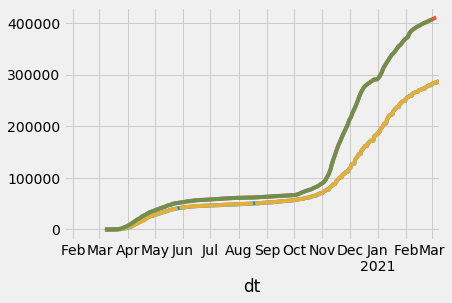

In [157]:
df_can.loc['CT', 'actuals.cases'].plot()
df_can.loc['CT', 'actuals.positiveTests'].plot()
df_can.loc['CT', 'actuals.newCases'].cumsum().plot()
df_st_testing_new.loc['CT', 'positive'].plot()


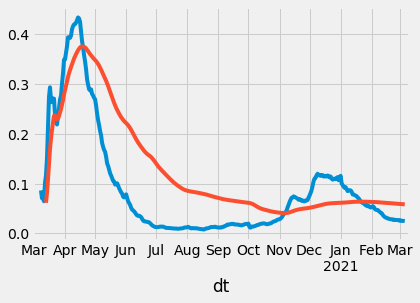

In [167]:
df_can.loc['CT','metrics.testPositivityRatio'].plot()
df_can.loc['CT','actuals.positiveTests'].rolling(7).sum().div(
df_can.loc['CT','actuals.positiveTests'].add(df_can.loc['CT','actuals.negativeTests']).rolling(7).sum()).plot()

In [173]:
pd.read_csv(
    'https://healthdata.gov/api/views/g62h-syeh/rows.csv?accessType=DOWNLOAD')

,state,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,...,inpatient_bed_covid_utilization_denominator,adult_icu_bed_covid_utilization,adult_icu_bed_covid_utilization_coverage,adult_icu_bed_covid_utilization_numerator,adult_icu_bed_covid_utilization_denominator,adult_icu_bed_utilization,adult_icu_bed_utilization_coverage,adult_icu_bed_utilization_numerator,adult_icu_bed_utilization_denominator,geocoded_state
0,AZ,2020/03/25,0,0,1,0,0,1,0.0,1,...,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-111.664616 34.293239)
1,NV,2020/03/20,0,0,1,0,0,1,0.0,1,...,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-114.916992 39.283294)
2,VA,2020/03/19,0,0,1,0,0,1,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-78.666382 37.510861)
3,VT,2020/03/19,0,0,1,0,0,1,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-72.662695 44.075252)
4,NE,2020/03/12,0,0,3,0,0,3,0.0,3,...,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-99.810595 41.527099)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19886,IN,2020/01/01,0,0,1,0,0,1,0.0,1,...,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-86.2818 39.919991)
19887,MT,2020/01/01,0,0,1,0,0,1,0.0,1,...,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-109.645127 47.033521)
19888,NC,2020/01/01,0,0,1,0,0,1,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-79.130883 35.52603)
19889,PR,2020/01/01,0,0,1,0,0,1,0.0,1,...,146.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-66.414655 18.215692)


In [178]:
df_hhs_hosp = pd.read_csv('https://healthdata.gov/api/views/jjp9-htie/rows.csv?accessType=DOWNLOAD')
df_hhs_hosp['state'] = df_hhs_hosp['state'].replace('CW', 'US')
df_hhs_hosp['dt'] = pd.to_datetime(df_hhs_hosp['collection_date']).dt.normalize()
df_hhs_hosp = df_hhs_hosp.set_index(['state', 'dt']).sort_index()

# df_hhs_hosp['Total Inpatient Beds'] = df_hhs_hosp['Total Inpatient Beds'].str.replace(',', '')
df_hhs_hosp['Total Inpatient Beds'] = pd.to_numeric(df_hhs_hosp['Total Inpatient Beds'], errors='coerce')

# df_hhs_hosp['Inpatient Beds Occupied Estimated'] = df_hhs_hosp['Inpatient Beds Occupied Estimated'].str.replace(',', '')
df_hhs_hosp['Inpatient Beds Occupied Estimated'] = pd.to_numeric(df_hhs_hosp['Inpatient Beds Occupied Estimated'], errors='coerce')

df_hhs_hosp['hosp_beds_avail'] = df_hhs_hosp['Total Inpatient Beds'] - df_hhs_hosp[
    'Inpatient Beds Occupied Estimated']
print('Got HHS hospitalization data.')

Got HHS hospitalization data.


In [179]:
df_hhs_hosp

collection_date  Inpatient Beds Occupied Estimated  Count LL  \
state dt                                                                        
AK    2021-02-07      2021/02/07                                797       797   
      2021-02-08      2021/02/08                                792       792   
      2021-02-09      2021/02/09                                794       794   
      2021-02-10      2021/02/10                                836       836   
      2021-02-11      2021/02/11                                845       845   
...                          ...                                ...       ...   
WY    2021-03-05      2021/03/05                                594       591   
      2021-03-06      2021/03/06                                532       529   
      2021-03-07      2021/03/07                                506       505   
      2021-03-08      2021/03/08                                518       518   
      2021-03-09      2021/03/09                                517       410   

                  Count UL  Percentage of Inpatient Beds Occupied Estimated  \
state dt                                                                      
AK    2021-02-07       797                                              797   
      2021-02-08       792                                              792   
      2021-02-09       794                                              794   
      2021-02-10       837                                              836   
      2021-02-11       845                                              845   
...                    ...                                              ...   
WY    2021-03-05       596                                              594   
      2021-03-06       535                                              532   
      2021-03-07       508                                              506   
      2021-03-08       518                                              518   
      2021-03-09       624                                              517   

                  Percentage LL  Percentage UL  Total Inpatient Beds  \
state dt                                                               
AK    2021-02-07          55.31          55.31                  1441   
      2021-02-08          53.80          53.80                  1472   
      2021-02-09          53.98          53.98                  1471   
      2021-02-10          56.87          56.87                  1471   
      2021-02-11          57.48          57.48                  1470   
...                         ...            ...                   ...   
WY    2021-03-05          40.62          41.93                  1438   
      2021-03-06          34.97          39.13                  1436   
      2021-03-07          35.22          35.22                  1438   
      2021-03-08          36.02          36.02                  1438   
      2021-03-09           6.21          65.70                  1438   

                  Total LL  Total UL                 geocoded_state  \
state dt                                                              
AK    2021-02-07      1441      1441  POINT (-151.631889 63.631126)   
      2021-02-08      1472      1472  POINT (-151.631889 63.631126)   
      2021-02-09      1471      1471  POINT (-151.631889 63.631126)   
      2021-02-10      1471      1471  POINT (-151.631889 63.631126)   
      2021-02-11      1470      1470  POINT (-151.631889 63.631126)   
...                    ...       ...                            ...   
WY    2021-03-05      1433      1443   POINT (-107.55145 42.999627)   
      2021-03-06      1413      1459   POINT (-107.55145 42.999627)   
      2021-03-07      1438      1438   POINT (-107.55145 42.999627)   
      2021-03-08      1438      1438   POINT (-107.55145 42.999627)   
      2021-03-09      1240      1636   POINT (-107.55145 42.999627)   

                  hosp_beds_avail  
state dt                           
AK